In [1]:
%reload_ext autoreload
%autoreload 2

In [5]:
import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
from mne.externals.h5io import read_hdf5, write_hdf5
from library import viz

from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.offline import plot
from plotly.graph_objs import Scatter
import plotly.tools as tls
import matplotlib

Managing fonts can be a pain ... 
This one brought the solution.

http://stackoverflow.com/questions/21461155/change-matplotlibs-default-font

Short: copy the fonts from mac and register them.

In [6]:
matplotlib.font_manager.fontManager.findfont('Helvetica')

u'/usr/share/fonts/myfonts/Helvetica.ttf'

In [7]:
import plotly.graph_objs as pgo
init_notebook_mode()

In [8]:
mne.utils.set_log_level('warning')

In [9]:
df = pd.read_csv('unrelated_MEG_subjects.csv')
subjects_missing = pd.read_csv('missing_freesurfer_s900_unrelated.csv').SubjectId.tolist()
subjects = [str(sub) for sub in df.Subject.tolist() if sub not in subjects_missing]

In [10]:
with open('unrelated_subjects.txt', 'w') as fid:
    fid.write('\n'.join(subjects))

In [8]:
# %%bash
# rm download_output.txt
# for sub in $(cat unrelated_subjects.txt)
# do
#     echo "downloading epochs for ${sub}" 
#     python hcp_compute_subject.py --storage_dir /mnt --hcp_no_anat --hcp_no_meg \
#     --subject $sub --downloaders "library:downloaders.get_single_trial_psd";
# done &> download_output.txt

In [11]:
recordings_path = '/mnt/hcp-meg'
pattern = 'psds-r{run}-0-150-epo.fif'

def get_epochs_for_subject(subject):
    epochs_list = list()
    for run_index in range(3):
        psd_fname = op.join(recordings_path, subject, pattern.format(run=run_index))
        if op.isfile(psd_fname):
            epochs = mne.read_epochs(psd_fname)
            epochs.events[:, 2].fill(run_index)
            epochs.event_id = {'run%d' % run_index: run_index}
            if epochs.info['nchan'] == 248:
                epochs_list.append(epochs)
    if epochs_list:
        epochs = mne.epochs.concatenate_epochs(epochs_list)
    else:
        epochs = None
    return epochs

In [12]:
epochs = get_epochs_for_subject(subjects[1])
X = np.log10(epochs.get_data())
freqs = np.linspace(0.001, 127, len(epochs.times))

In [13]:
from hcp.preprocessing import make_hcp_bti_layout
lout = make_hcp_bti_layout(info=epochs.info)

In [14]:
epochs.times[:] = freqs

In [15]:
import seaborn as sns
sns.set(style='ticks', palette='Set2')
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 


In [16]:
def plot_topomap(inst, points, unit, cmap='magma', time_format='%0.2fHZ', **kwargs):
    return inst.plot_topomap(
        points, scale=1, size=2, vmin=np.min, vmax=np.max, cmap=cmap,
        contours=0, scale_time=1, time_format=time_format, layout=lout, unit=unit, **kwargs);

In [17]:
for subject in subjects:
    %run hcp_compute_subject.py --storage_dir /mnt \
    --subject $subject \
    --hcp_no_meg --hcp_no_anat \
    --keep_files \
    --s3_overwrite_downloads \
    --downloaders '~/github/meg_study_dynamic_scales/scripts/library:downloaders.get_1of_sensor_outputs'\

Elapsed time downloading hcp-meg-data from s3 00:00:00
calling "download_only./home/ubuntu/github/meg_study_dynamic_scales/scripts/hcp_compute_subject" with:
	subject: 599671
downloading only
Elapsed time for running scripts 00:00:00


/home/ubuntu/miniconda2/envs/swish/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:

 This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.




Elapsed time downloading hcp-meg-data from s3 00:00:00
calling "download_only./home/ubuntu/github/meg_study_dynamic_scales/scripts/hcp_compute_subject" with:
	subject: 665254
downloading only
Elapsed time for running scripts 00:00:00
Elapsed time downloading hcp-meg-data from s3 00:00:00
calling "download_only./home/ubuntu/github/meg_study_dynamic_scales/scripts/hcp_compute_subject" with:
	subject: 825048
downloading only
Elapsed time for running scripts 00:00:00
Elapsed time downloading hcp-meg-data from s3 00:00:00
calling "download_only./home/ubuntu/github/meg_study_dynamic_scales/scripts/hcp_compute_subject" with:
	subject: 877168
downloading only
Elapsed time for running scripts 00:00:00
Elapsed time downloading hcp-meg-data from s3 00:00:00
calling "download_only./home/ubuntu/github/meg_study_dynamic_scales/scripts/hcp_compute_subject" with:
	subject: 814649
downloading only
Elapsed time for running scripts 00:00:00
Elapsed time downloading hcp-meg-data from s3 00:00:00
calling "

In [18]:
arrythmic_fnames = glob.glob('/mnt/hcp-meg/??????/psds-loglinear-fit-0p1-1.h5')

arr_map = {fname.split('/')[3]: fname for fname in arrythmic_fnames}

epo_map = dict()
for fname in glob.glob(op.join(recordings_path, '??????', '*epo.fif')):
    subject = fname.split('/')[3]
    if subject not in epo_map:
        epo_map[subject] = list()
    epo_map[subject].append(fname)

In [44]:
arr = mne.externals.h5io.read_hdf5(arr_map[subjects[1]])

In [45]:
np.mean(np.mean(arr['intercepts'],0), 0) * 10

-234.21110033022458

# Figure 1 materials

a) show for 1 subject alpha, 1/f and topos

b) show psds for all subjects

c) show grand averages

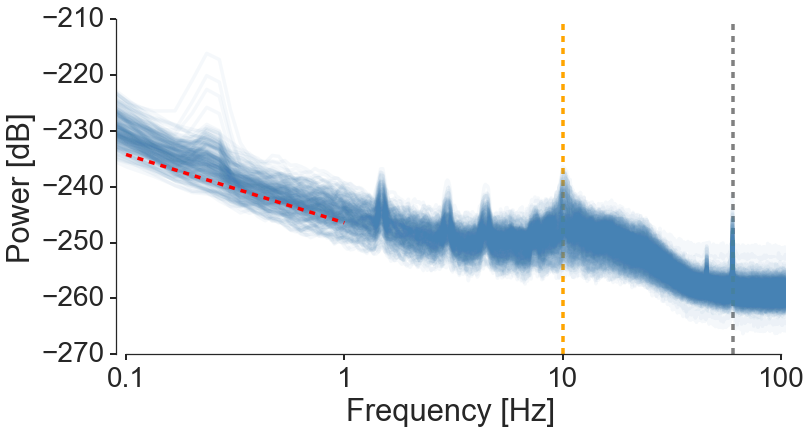

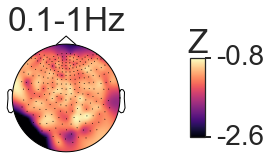

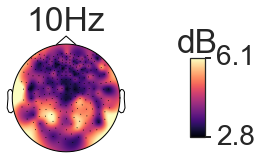

In [152]:
%matplotlib inline
width = 2

sns.set_context("paper", font_scale=3.5,
                rc={"lines.linewidth": 3.5,'axes.linewidth': width,
                    'ytick.major.width': width, 'ytick.minor.width': width,
                    'xtick.major.width': width, 'xtick.minor.width': width})
#
fig, axes = plt.subplots(1, 1, figsize=(12, 6), dpi=300)
ax = axes
ax.axvline(np.log10(10), color='orange', linestyle='--')
ax.axvline(np.log10(60), color='gray', linestyle='--')
ax.axvline(np.log10(120), color='gray', linestyle='--')

ax.plot(np.log10(freqs), X.mean(0).T * 10, color='steelblue',
         alpha=0.05)

arr_range = np.array([[
    arr['intercepts'].mean(0).mean(0),
    arr['intercepts'].mean(0).mean(0) + arr['coefs'].mean(0).mean(0)
]]).T
ax.plot(np.log10([0.1, 1.0]), arr_range * 10, color='red',
        linestyle='--')
ax.set_xticks(np.log10([0.1, 1, 10, 100]))
ax.set_xticklabels([0.1, 1, 10, 100])
ax.set_xlim(np.log10([0.09, 105]))
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power [dB]')

sns.despine(trim=True)

coefs_mne = mne.EvokedArray((arr['coefs']).mean(0, keepdims=True).T,
                            info=epochs.info, tmin=0)
plot_topomap(coefs_mne, [0], unit='Z', title='', time_format='0.1-1Hz');

power_mne = mne.EvokedArray(X[...,
                              np.argmin(np.abs(freqs-10))].std(0)[..., None] * 10,
                            info=epochs.info, tmin=0)
plot_topomap(power_mne, [0], unit='dB', title='', time_format='10Hz');


In [22]:
df_roi = pd.read_csv('meg_sensor_rois.csv')

In [23]:
rois = df_roi.columns[2:]
print rois

Index([u'frontal_inner_right', u'central', u'temporal_right', u'parietal_left',
       u'frontal', u'frontal_outer_right', u'frontal_inner_left',
       u'parietal_right', u'frontal_outer_left', u'parietal_center',
       u'occiptial', u'temporal_left'],
      dtype='object')


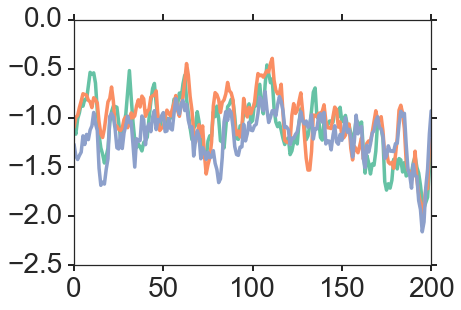

In [24]:
plt.plot(np.array([arr['coefs'][:, df_roi[roi].values].mean(1) for roi in rois if 'parietal' in roi]).T);

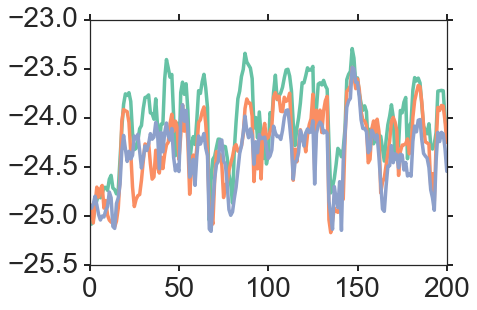

In [25]:
plt.plot(np.array([X[:, df_roi[roi].values].mean(1)[:, 300] for roi in rois if 'parietal' in roi]).T);

In [124]:
roi_power = np.array([X[:, df_roi[roi].values].mean(1)[:, 300] for roi in rois])

roi_coef = np.array([arr['coefs'][:, df_roi[roi].values].mean(1) for roi in rois])

roi_mse = np.array([arr['msq'][:, df_roi[roi].values].mean(1) for roi in rois])

In [79]:
corrs = np.corrcoef(roi_power[:, :],
                    np.log10(roi_coef[:, :] ** 2))
corrs.shape

(24, 24)

(<matplotlib.image.AxesImage at 0x7feb81b48050>,
 <matplotlib.colorbar.Colorbar at 0x7feb81ac7a90>)

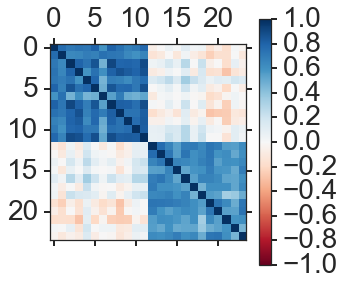

In [77]:
plt.matshow(corrs, cmap='RdBu', vmin=-1, vmax=1), plt.colorbar()

In [69]:
all_subjects = list(set(arr_map).intersection(set(epo_map)))

In [78]:
roi_power.shape
roi_coef.shape

(12, 201)

In [135]:
from scipy.stats import percentileofscore

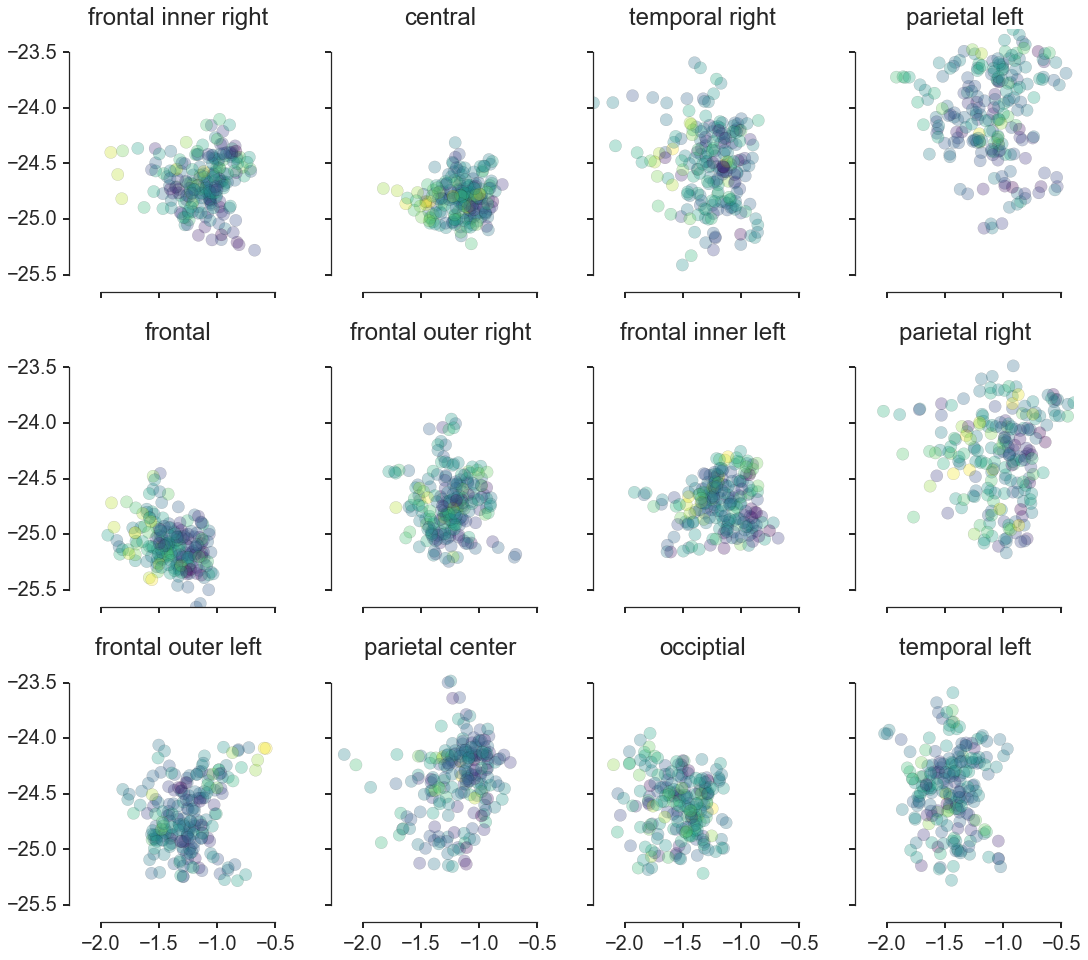

In [151]:
%matplotlib inline
sns.set_context("paper", font_scale=2.5,
                rc={"lines.linewidth": 3.5,'axes.linewidth': width,
                    'ytick.major.width': width, 'ytick.minor.width': width,
                    'xtick.major.width': width, 'xtick.minor.width': width})

val_range_x = [roi_coef.min(), roi_coef.max()]
val_range_y = [roi_power.min(), roi_power.max()]

fig, axes = plt.subplots(3, 4, figsize=(18, 16), sharex=True, sharey=True)
axes = axes.ravel()
for ax, y, x, z, name in zip(axes, roi_power, roi_coef, roi_mse, rois):
    ax.scatter(x, y, c=z, cmap='viridis', alpha=0.3, s=150)
    ax.set_title(name.replace('_',  ' '))
    ax.set_xlim(*val_range_x)
    ax.set_ylim(*val_range_y)
sns.despine(trim=True)

# notes
- lag analysis
- 5 subjects + source space
- correlate alpha power changes to patterns